<a href="https://colab.research.google.com/github/sidgtx/projectx/blob/main/neuralnet/neuralpde/pde_models-I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lotka-Voltera Dynamics

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



Compiling model...
Building feed-forward neural network...
'build' took 0.114214 s

'compile' took 1.173558 s

Training model...

Step      Train loss              Test loss               Test metric
0         [2.08e+02, 1.37e+00]    [2.08e+02, 1.37e+00]    []  
1000      [2.54e+00, 4.86e-01]    [2.44e+00, 4.80e-01]    []  
2000      [1.74e+00, 5.22e-01]    [1.65e+00, 5.12e-01]    []  
3000      [1.22e+00, 4.72e-01]    [1.15e+00, 4.59e-01]    []  
4000      [7.45e-01, 3.96e-01]    [6.99e-01, 3.83e-01]    []  
5000      [4.31e-01, 3.24e-01]    [4.07e-01, 3.12e-01]    []  
6000      [2.71e-01, 2.42e-01]    [2.60e-01, 2.33e-01]    []  
7000      [1.29e-01, 2.22e-01]    [1.25e-01, 2.15e-01]    []  
8000      [8.92e-02, 1.52e-01]    [8.75e-02, 1.47e-01]    []  
9000      [7.09e-02, 1.18e-01]    [7.03e-02, 1.15e-01]    []  
10000     [5.66e-02, 9.90e-02]    [5.64e-02, 9.65e-02]    []  
11000     [4.54e-02, 1.17e-01]    [4.53e-02, 1.16e-01]    []  
12000     [7.49e-02, 6.13e-02]    [7.49e-02,

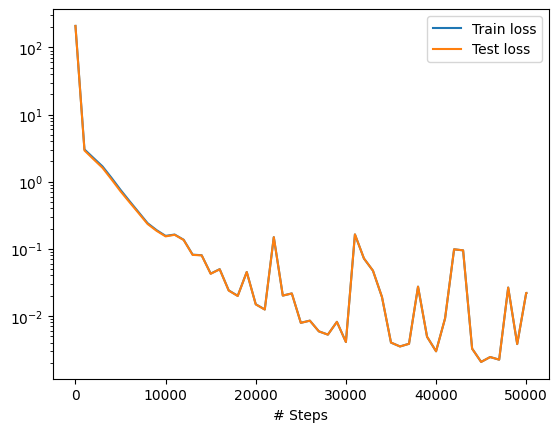

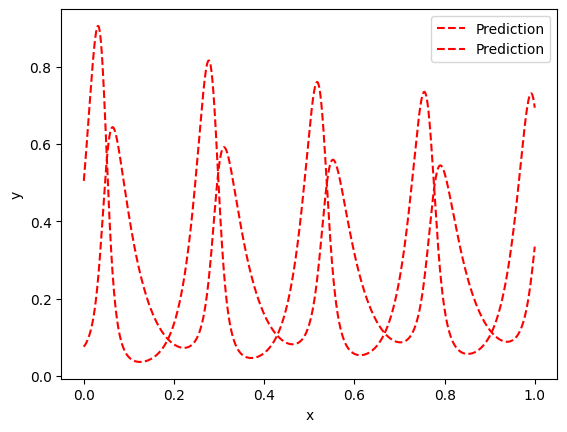

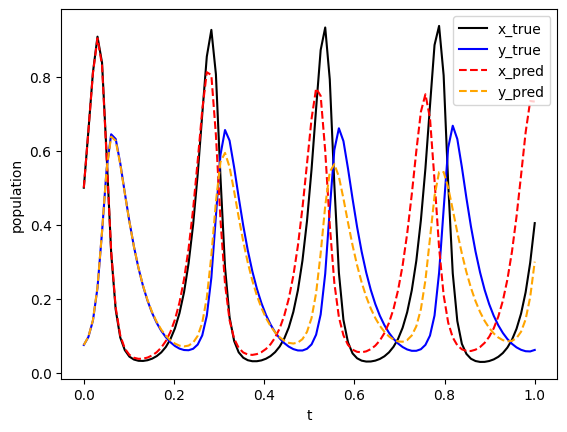

In [3]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle, jax"""

import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate

# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf

# Import torch if using backend pytorch
# import torch
# Import paddle if using backend paddle
# import paddle
# Import jax.numpy if using backend jax
# import jax.numpy as jnp

ub = 200
rb = 20


def func(t, r):
    x, y = r
    dx_t = 1 / ub * rb * (2.0 * ub * x - 0.04 * ub * x * ub * y)
    dy_t = 1 / ub * rb * (0.02 * ub * x * ub * y - 1.06 * ub * y)
    return dx_t, dy_t


def gen_truedata():
    t = np.linspace(0, 1, 100)

    sol = integrate.solve_ivp(func, (0, 10), (100 / ub, 15 / ub), t_eval=t)
    x_true, y_true = sol.y
    x_true = x_true.reshape(100, 1)
    y_true = y_true.reshape(100, 1)

    return x_true, y_true


def ode_system(x, y):
    # Most backends
    r = y[:, 0:1]
    p = y[:, 1:2]
    dr_t = dde.grad.jacobian(y, x, i=0)
    dp_t = dde.grad.jacobian(y, x, i=1)
    # Backend jax
    # y_val, y_fn = y
    # r = y_val[:, 0:1]
    # p = y_val[:, 1:2]
    # dr_t, _ = dde.grad.jacobian(y, x, i=0)
    # dp_t, _ = dde.grad.jacobian(y, x, i=1)
    return [
        dr_t - 1 / ub * rb * (2.0 * ub * r - 0.04 * ub * r * ub * p),
        dp_t - 1 / ub * rb * (0.02 * r * ub * p * ub - 1.06 * p * ub),
    ]


geom = dde.geometry.TimeDomain(0, 1.0)
data = dde.data.PDE(geom, ode_system, [], 3000, 2, num_test=3000)

layer_size = [1] + [64] * 6 + [2]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)


# Backend tensorflow.compat.v1 or tensorflow
def input_transform(t):
    return tf.concat(
        (
            t,
            tf.sin(t),
            tf.sin(2 * t),
            tf.sin(3 * t),
            tf.sin(4 * t),
            tf.sin(5 * t),
            tf.sin(6 * t),
        ),
        axis=1,
    )


# Backend pytorch
# def input_transform(t):
#     return torch.cat(
#         [
#             torch.sin(t),
#         ],
#         dim=1,
#     )
# Backend paddle
# def input_transform(t):
#     return paddle.concat(
#         (
#             paddle.sin(t),
#         ),
#         axis=1,
#     )
# Backend jax
# def input_transform(t):
#     if t.ndim == 1:
#         t = t[None]
#
#     return jnp.concatenate(
#         [
#             jnp.sin(t),
#         ],
#         axis=1
#     )


# hard constraints: x(0) = 100, y(0) = 15
# Backend tensorflow.compat.v1 or tensorflow
def output_transform(t, y):
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]
    return tf.concat([y1 * tf.tanh(t) + 100 / ub, y2 * tf.tanh(t) + 15 / ub], axis=1)


# Backend pytorch
# def output_transform(t, y):
#     y1 = y[:, 0:1]
#     y2 = y[:, 1:2]
#     return torch.cat([y1 * torch.tanh(t) + 100 / ub, y2 * torch.tanh(t) + 15 / ub], dim=1)
# Backend paddle
# def output_transform(t, y):
#     y1 = y[:, 0:1]
#     y2 = y[:, 1:2]
#     return paddle.concat([y1 * paddle.tanh(t) + 100 / ub, y2 * paddle.tanh(t) + 15 / ub], axis=1)
# Backend jax
# def output_transform(t, y):
#     y1 = y[:, 0:1]
#     y2 = y[:, 1:2]
#     return jnp.concatenate(
#         [y1 * jnp.tanh(t) + 100 / ub, y2 * jnp.tanh(t) + 15 / ub],
#         axis=1
#     ).squeeze()

net.apply_feature_transform(input_transform)
net.apply_output_transform(output_transform)
model = dde.Model(data, net)

model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=50000)
# Most backends except jax can have a second fine tuning of the solution
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

plt.xlabel("t")
plt.ylabel("population")

t = np.linspace(0, 1, 100)
x_true, y_true = gen_truedata()
plt.plot(t, x_true, color="black", label="x_true")
plt.plot(t, y_true, color="blue", label="y_true")

t = t.reshape(100, 1)
sol_pred = model.predict(t)
x_pred = sol_pred[:, 0:1]
y_pred = sol_pred[:, 1:2]

plt.plot(t, x_pred, color="red", linestyle="dashed", label="x_pred")
plt.plot(t, y_pred, color="orange", linestyle="dashed", label="y_pred")
plt.legend()
plt.show()

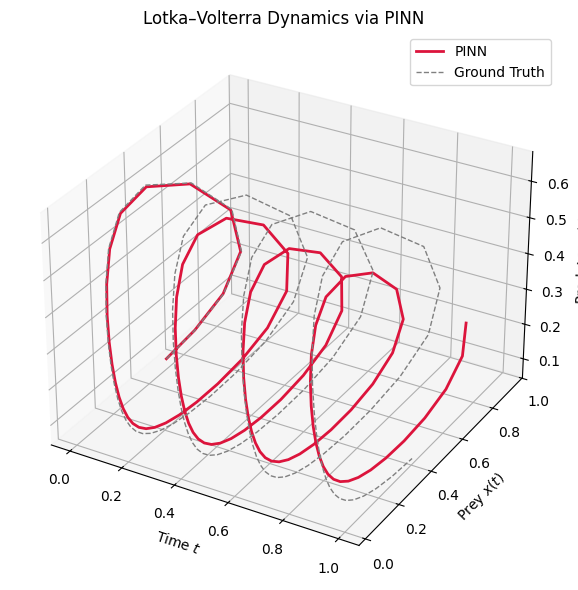

In [4]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")

# t is time, x_pred and y_pred are populations
ax.plot(
    t.flatten(), x_pred.flatten(), y_pred.flatten(), color="crimson", lw=2, label="PINN"
)
ax.plot(
    t.flatten(),
    x_true.flatten(),
    y_true.flatten(),
    color="gray",
    lw=1,
    linestyle="--",
    label="Ground Truth",
)

ax.set_xlabel("Time $t$")
ax.set_ylabel("Prey $x(t)$")
ax.set_zlabel("Predator $y(t)$")
ax.set_title("Lotka–Volterra Dynamics via PINN")
ax.legend()
plt.tight_layout()
plt.show()

## Reaction-Diffusion 1D

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Compiling model...
Building feed-forward neural network...
'build' took 0.171609 s

'compile' took 1.618166 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.64e+01]    [5.83e+01]    [4.77e+00]    
1000      [1.92e+00]    [1.95e+00]    [1.58e-01]    
2000      [3.52e-01]    [3.36e-01]    [1.97e-02]    
3000      [1.13e-01]    [1.07e-01]    [1.77e-02]    
4000      [2.44e-02]    [2.38e-02]    [1.02e-02]    
5000      [1.46e-02]    [1.43e-02]    [7.82e-03]    
6000      [3.81e-02]    [3.81e-02]    [7.10e-02]    
7000      [5.41e-03]    [5.50e-03]    [7.37e-03]    
8000      [4.39e-02]    [4.39e-02]    [8.27e-02]    
9000      [2.37e-03]    [2.55e-03]    [6.15e-03]    
10000     [4.7

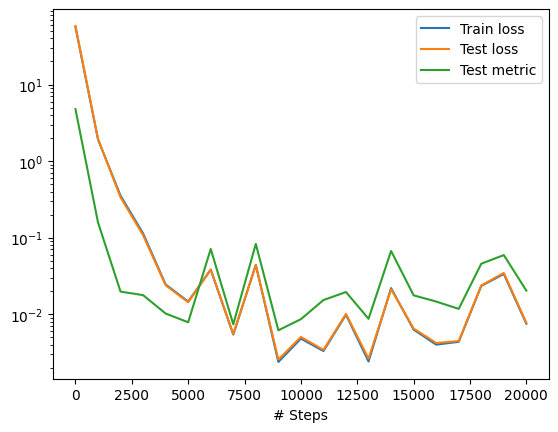

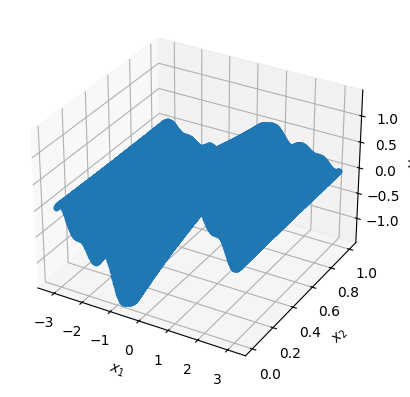

In [3]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""

import deepxde as dde
import numpy as np

# Backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf

# Backend pytorch
# import torch
# Backend paddle
# import paddle


def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    d = 1
    # Backend tensorflow.compat.v1 or tensorflow
    return (
        dy_t
        - d * dy_xx
        - tf.exp(-x[:, 1:])
        * (
            3 * tf.sin(2 * x[:, 0:1]) / 2
            + 8 * tf.sin(3 * x[:, 0:1]) / 3
            + 15 * tf.sin(4 * x[:, 0:1]) / 4
            + 63 * tf.sin(8 * x[:, 0:1]) / 8
        )
    )
    # Backend pytorch
    # return (
    #     dy_t
    #     - d * dy_xx
    #     - torch.exp(-x[:, 1:])
    #     * (3 * torch.sin(2 * x[:, 0:1]) / 2
    #        + 8 * torch.sin(3 * x[:, 0:1]) / 3
    #        + 15 * torch.sin(4 * x[:, 0:1]) / 4
    #        + 63 * torch.sin(8 * x[:, 0:1]) / 8
    #     )
    # )
    # Backend paddle
    # return (
    #     dy_t
    #     - d * dy_xx
    #     - paddle.exp(-x[:, 1:])
    #     * (3 * paddle.sin(2 * x[:, 0:1]) / 2
    #        + 8 * paddle.sin(3 * x[:, 0:1]) / 3
    #        + 15 * paddle.sin(4 * x[:, 0:1]) / 4
    #        + 63 * paddle.sin(8 * x[:, 0:1]) / 8
    #     )
    # )


def func(x):
    return np.exp(-x[:, 1:]) * (
        np.sin(x[:, 0:1])
        + np.sin(2 * x[:, 0:1]) / 2
        + np.sin(3 * x[:, 0:1]) / 3
        + np.sin(4 * x[:, 0:1]) / 4
        + np.sin(8 * x[:, 0:1]) / 8
    )


geom = dde.geometry.Interval(-np.pi, np.pi)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

data = dde.data.TimePDE(
    geomtime, pde, [], num_domain=320, solution=func, num_test=80000
)

layer_size = [2] + [30] * 6 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)


# Backend tensorflow.compat.v1 or tensorflow
def output_transform(x, y):
    return (
        x[:, 1:2] * (np.pi**2 - x[:, 0:1] ** 2) * y
        + tf.sin(x[:, 0:1])
        + tf.sin(2 * x[:, 0:1]) / 2
        + tf.sin(3 * x[:, 0:1]) / 3
        + tf.sin(4 * x[:, 0:1]) / 4
        + tf.sin(8 * x[:, 0:1]) / 8
    )


# Backend pytorch
# def output_transform(x, y):
#     return (
#         x[:, 1:2] * (np.pi ** 2 - x[:, 0:1] ** 2) * y
#         + torch.sin(x[:, 0:1])
#         + torch.sin(2 * x[:, 0:1]) / 2
#         + torch.sin(3 * x[:, 0:1]) / 3
#         + torch.sin(4 * x[:, 0:1]) / 4
#         + torch.sin(8 * x[:, 0:1]) / 8
#    )
# Backend paddle
# def output_transform(x, y):
#     return (
#         x[:, 1:2] * (np.pi ** 2 - x[:, 0:1] ** 2) * y
#         + paddle.sin(x[:, 0:1])
#         + paddle.sin(2 * x[:, 0:1]) / 2
#         + paddle.sin(3 * x[:, 0:1]) / 3
#         + paddle.sin(4 * x[:, 0:1]) / 4
#         + paddle.sin(8 * x[:, 0:1]) / 8
#    )

net.apply_output_transform(output_transform)

model = dde.Model(data, net)
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

## Reaction-Diffusion 2D (Fourier Transformed)

Compiling model...
Building feed-forward neural network...
'build' took 0.072281 s

'compile' took 0.978752 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [4.39e-02, 8.26e-01, 1.20e+00, 1.12e+00, 4.59e-03, 1.70e-02]    [4.27e-02, 8.24e-01, 1.20e+00, 1.12e+00, 4.59e-03, 1.70e-02]    []  
1000      [2.18e-05, 2.17e-05, 1.57e-05, 1.31e-05, 3.21e-05, 2.34e-05]    [9.64e-06, 8.78e-06, 1.61e-05, 1.32e-05, 3.21e-05, 2.34e-05]    []  
2000      [1.35e-05, 2.46e-05, 1.11e-05, 9.87e-06, 1.25e-05, 4.87e-06]    [1.02e-05, 1.89e-05, 1.14e-05, 9.73e-06, 1.25e-05, 4.87e-06]    []  
3000      [5.10e-06, 7.35e-06, 9.91e-06, 9.31e-06, 6.88e-06, 3.11e-06]    [2.92e-06, 3.37e-06, 1.01e-05, 9.09e-06, 6.88e-06, 3.11e-06]    []  
4000      [3.11e-06, 4.23e-06, 9.09e-06, 8.97e-06, 3.75e-06, 2.08e-06]    [1.86e-06, 1.49e-06, 9.28e-06, 8.75e-06, 3.75e-06, 2.08e-06]    []  
5000 

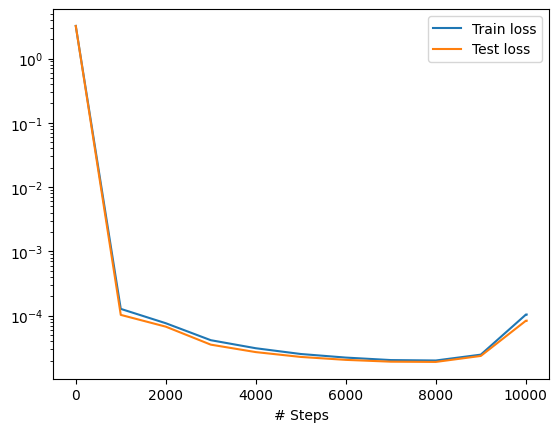

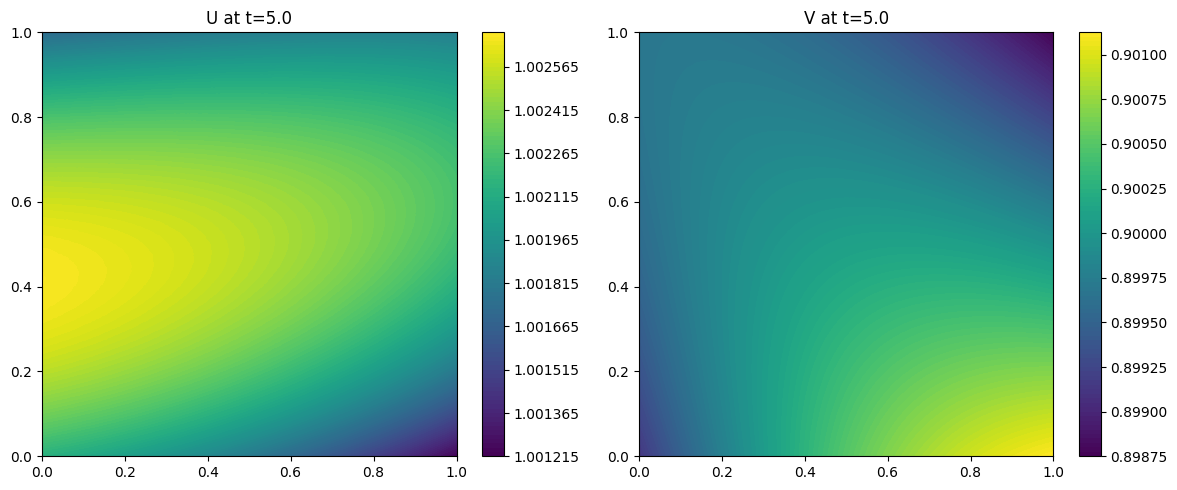

In [14]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from deepxde.backend import tf

# Set random seed for reproducibility
dde.config.set_random_seed(42)

# Parameters for the Schnakenberg model
Du = 1e-5
Dv = 1e-3
a = 0.1
b = 0.9


# Fourier feature mapping for high-frequency representation
def fourier_features(x, num_features=256):
    """Generate Fourier features for input x."""
    L = 1.0  # Domain length
    scale = 2 * np.pi * np.linspace(1, num_features, num_features) / L
    return np.concatenate([np.sin(scale * x), np.cos(scale * x)], axis=-1)


# Define the neural network with Fourier feature input
def neural_network(x):
    """Define the neural network architecture."""
    x = fourier_features(x)
    net = dde.nn.FNN(
        [x.shape[1]] + [128] * 4 + [2],
        activation="tanh",
        kernel_initializer="Glorot uniform",
    )
    return net(x)


# Define the PDE system (Schnakenberg model)
def pde(x, y):
    """Define the PDE system."""
    u, v = y[:, 0:1], y[:, 1:2]
    u_t = dde.grad.jacobian(y, x, i=0, j=2)
    v_t = dde.grad.jacobian(y, x, i=1, j=2)
    u_xx = dde.grad.hessian(y, x, i=0, j=0)
    u_yy = dde.grad.hessian(y, x, i=0, j=1)
    v_xx = dde.grad.hessian(y, x, i=1, j=0)
    v_yy = dde.grad.hessian(y, x, i=1, j=1)
    return [
        u_t - Du * (u_xx + u_yy) - (a - u + u**2 * v),
        v_t - Dv * (v_xx + v_yy) - (b - u**2 * v),
    ]


# Define the spatial and temporal domains
geom = dde.geometry.Rectangle([0, 0], [1, 1])
timedomain = dde.geometry.TimeDomain(0, 10)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


# Initial conditions with small random perturbations
def initial_u(x):
    return a + b + 0.01 * np.random.rand(*x[:, 0:1].shape)


def initial_v(x):
    return b / (a + b) ** 2 + 0.01 * np.random.rand(*x[:, 0:1].shape)


ic_u = dde.icbc.IC(geomtime, initial_u, lambda x, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, initial_v, lambda x, on_initial: on_initial, component=1)

# Neumann (zero-flux) boundary conditions
bc_u = dde.icbc.NeumannBC(
    geomtime, lambda x: 0, lambda x, on_boundary: on_boundary, component=0
)
bc_v = dde.icbc.NeumannBC(
    geomtime, lambda x: 0, lambda x, on_boundary: on_boundary, component=1
)

# Define the data
data = dde.data.TimePDE(
    geomtime,
    pde,
    [ic_u, ic_v, bc_u, bc_v],
    num_domain=40000,
    num_boundary=2000,
    num_initial=2000,
    num_test=1000,
)

# Define the model
net = dde.nn.FNN(
    [3] + [128] * 4 + [2], activation="tanh", kernel_initializer="Glorot uniform"
)
model = dde.Model(data, net)

# Compile and train the model
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=10000)

# Optional: Fine-tune with L-BFGS optimizer
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Save and plot the results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


# Function to plot the solution at a specific time snapshot
def plot_snapshot(model, t_snap=5.0, resolution=200):
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, 1, resolution)
    X, Y = np.meshgrid(x, y)
    T = np.full_like(X, t_snap)
    input_points = np.vstack((X.flatten(), Y.flatten(), T.flatten())).T
    pred = model.predict(input_points)
    u = pred[:, 0].reshape(resolution, resolution)
    v = pred[:, 1].reshape(resolution, resolution)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"U at t={t_snap}")
    plt.contourf(X, Y, u, levels=100, cmap="viridis")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title(f"V at t={t_snap}")
    plt.contourf(X, Y, v, levels=100, cmap="viridis")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


# Plot the solution at t = 5.0
plot_snapshot(model, t_snap=5.0)